In [ ]:
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import nibabel as nib # To handle Nifty files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from skimage.transform import resize

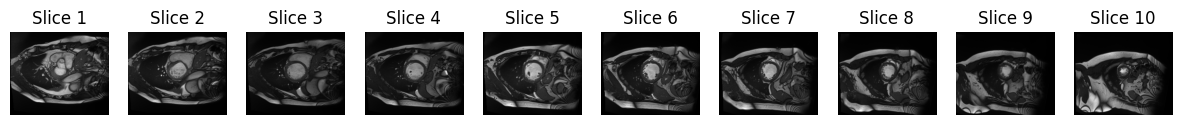

In [ ]:
def load_and_visualize_nifti(nifti_file):
    # Load the NIfTI file
    img = nib.load(nifti_file) # img is type of <class 'nibabel.nifti1.Nifti1Image'>

    # Get the image data as a NumPy array
    img_data = img.get_fdata()  # img_data is type of <class 'numpy.ndarray'>

    # print(img_data.shape)  # if you have an MRI scan with a resolution of 216 pixels in the vertical direction, 256 pixels in the horizontal direction, and 10 slices in the depth direction, then the shape of the array would be (216, 256, 10). So it can correspond to height, width and depth (or number of slices)

    # Plot slices along the z-axis
    num_slices = img_data.shape[2] # num_slices contains 10

    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

    for i in range(num_slices):
        slice_data = img_data[:, :, i]
        axes[i].imshow(slice_data, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Slice {i + 1}")

    plt.show()

# Patient 1 Frame 01 Original Image
nifti_file_path = "/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Training/patient001/patient001_frame01.nii.gz"
load_and_visualize_nifti(nifti_file_path)


<class 'nibabel.nifti1.Nifti1Image'>
<class 'numpy.ndarray'>
10


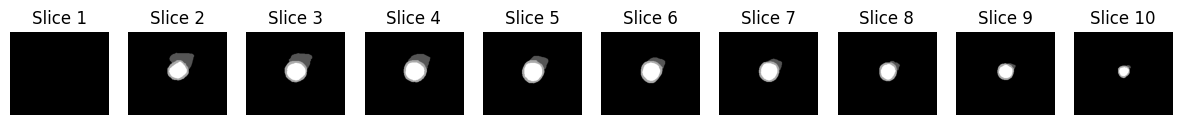

In [ ]:
# Patient 1 Frame 01 Ground Truth
nifti_file_path = "/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Training/patient001/patient001_frame01_gt.nii.gz"
load_and_visualize_nifti(nifti_file_path)

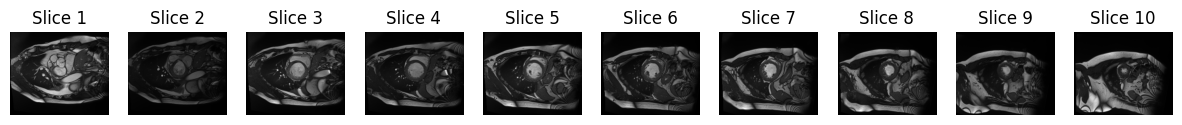

In [ ]:
# Patient 1 Frame 12 Original Image
nifti_file_path = "/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Training/patient001/patient001_frame12.nii.gz"
load_and_visualize_nifti(nifti_file_path)

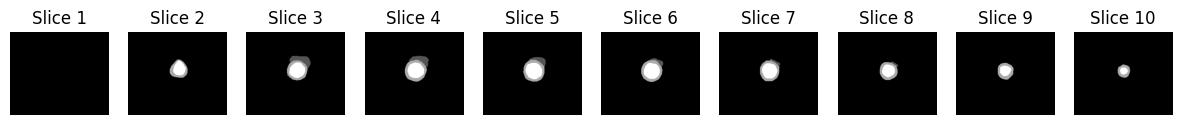

In [ ]:
# Patient 1 Frame 12 Ground Truth
nifti_file_path = "/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Training/patient001/patient001_frame12_gt.nii.gz"
load_and_visualize_nifti(nifti_file_path)

In [ ]:
# def unet_model(input_shape=(256, 256, 1)):
#     inputs = Input(input_shape)
#     print('Input Image:(UNET MODEL VARIABLE):',inputs)

#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     # Decoder
#     conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
#     up1 = UpSampling2D(size=(2, 2))(conv2)

#     # Output layer
#     output_layer = Conv2D(1, 1, activation='sigmoid')(up1)

#     model = Model(inputs=inputs, outputs=output_layer)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [ ]:


def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:

def load_data(folder_path):
    X = []
    y = []

    for patient_folder in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, patient_folder)):
            cfg_file = os.path.join(folder_path, patient_folder, f"{patient_folder}.cfg")

            # Get the list of all NIfTI files in the folder
            nifty_files = [f for f in os.listdir(os.path.join(folder_path, patient_folder)) if f.endswith('.nii.gz')]

            # Exclude files containing '4d' in their names
            nifty_files = [file for file in nifty_files if '4d' not in file]
            print(nifty_files)

            for nifty_file in nifty_files:
                if "_gt" in nifty_file:  # Ground truth file
                    y_path = os.path.join(folder_path, patient_folder, nifty_file)
                    y_data = nib.load(y_path).get_fdata()
                    print(f"Shape of {nifty_file}: {y_data.shape}")
                    y.append(y_data)
                else:  # Input file
                    x_path = os.path.join(folder_path, patient_folder, nifty_file)
                    x_data = nib.load(x_path).get_fdata()
                    print(f"Shape of {nifty_file}: {x_data.shape}")
                    X.append(x_data)

    return X, y


In [ ]:
data_folder = r'/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Training'
X_data, y_data = load_data(data_folder)

['patient096_frame08.nii.gz', 'patient096_frame01.nii.gz', 'patient096_frame08_gt.nii.gz', 'patient096_frame01_gt.nii.gz']
Shape of patient096_frame08.nii.gz: (174, 208, 18)
Shape of patient096_frame01.nii.gz: (174, 208, 18)
Shape of patient096_frame08_gt.nii.gz: (174, 208, 18)
Shape of patient096_frame01_gt.nii.gz: (174, 208, 18)
['patient098_frame01_gt.nii.gz', 'patient098_frame09.nii.gz', 'patient098_frame09_gt.nii.gz', 'patient098_frame01.nii.gz']
Shape of patient098_frame01_gt.nii.gz: (216, 256, 7)
Shape of patient098_frame09.nii.gz: (216, 256, 7)
Shape of patient098_frame09_gt.nii.gz: (216, 256, 7)
Shape of patient098_frame01.nii.gz: (216, 256, 7)
['patient094_frame01_gt.nii.gz', 'patient094_frame01.nii.gz', 'patient094_frame07.nii.gz', 'patient094_frame07_gt.nii.gz']
Shape of patient094_frame01_gt.nii.gz: (208, 174, 10)
Shape of patient094_frame01.nii.gz: (208, 174, 10)
Shape of patient094_frame07.nii.gz: (208, 174, 10)
Shape of patient094_frame07_gt.nii.gz: (208, 174, 10)
['pat

In [ ]:
# Dimensions
num_rows = len(X_data)
num_columns = len(X_data[0])
print('Original Image Dimeensions:', num_rows, num_columns)

Original Image Dimeensions: 200 174


In [ ]:
X_data[0].shape

(174, 208, 18)

In [ ]:
X_data[0]

array([[[30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.],
        ...,
        [30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.]],

       [[30., 30., 31., ..., 30., 31., 31.],
        [31., 32., 32., ..., 30., 31., 31.],
        [33., 33., 34., ..., 30., 31., 31.],
        ...,
        [31., 31., 32., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.]],

       [[30., 30., 31., ..., 30., 31., 31.],
        [32., 32., 33., ..., 30., 31., 31.],
        [33., 34., 34., ..., 30., 31., 31.],
        ...,
        [31., 31., 32., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.]],

       ...,

       [[30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.],
        [30., 30., 31., ..., 30., 31., 31.

In [ ]:

def load_data(folder_path):
    X = []
    y = []

    for patient_folder in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, patient_folder)):
            cfg_file = os.path.join(folder_path, patient_folder, f"{patient_folder}.cfg")

            # Get the list of all NIfTI files in the folder
            nifty_files = [f for f in os.listdir(os.path.join(folder_path, patient_folder)) if f.endswith('.nii.gz')]

            # Exclude files containing '4d' in their names
            nifty_files = [file for file in nifty_files if '4d' not in file]
            print(nifty_files)

            for nifty_file in nifty_files:
                if "_gt" in nifty_file:  # Ground truth file
                    y_path = os.path.join(folder_path, patient_folder, nifty_file)
                    y_data = nib.load(y_path).get_fdata()
                    print(f"Shape of {nifty_file}: {y_data.shape}")
                    y.append(y_data)
                else:  # Input file
                    x_path = os.path.join(folder_path, patient_folder, nifty_file)
                    x_data = nib.load(x_path).get_fdata()
                    print(f"Shape of {nifty_file}: {x_data.shape}")
                    X.append(x_data)

    X = np.array(X)
    y = np.array(y)

    return X, y


In [ ]:
data_folder = r'/content/drive/MyDrive/ColabNotebooks/Training'
X_data, y_data = load_data(data_folder)

['patient039_frame10_gt.nii.gz', 'patient039_frame10.nii.gz', 'patient039_frame01.nii.gz', 'patient039_frame01_gt.nii.gz']
Shape of patient039_frame10_gt.nii.gz: (208, 256, 9)
Shape of patient039_frame10.nii.gz: (208, 256, 9)
Shape of patient039_frame01.nii.gz: (208, 256, 9)
Shape of patient039_frame01_gt.nii.gz: (208, 256, 9)
['patient038_frame11.nii.gz', 'patient038_frame01.nii.gz', 'patient038_frame11_gt.nii.gz', 'patient038_frame01_gt.nii.gz']
Shape of patient038_frame11.nii.gz: (276, 384, 8)
Shape of patient038_frame01.nii.gz: (276, 384, 8)
Shape of patient038_frame11_gt.nii.gz: (276, 384, 8)
Shape of patient038_frame01_gt.nii.gz: (276, 384, 8)
['patient037_frame12.nii.gz', 'patient037_frame01.nii.gz', 'patient037_frame12_gt.nii.gz', 'patient037_frame01_gt.nii.gz']
Shape of patient037_frame12.nii.gz: (216, 256, 7)
Shape of patient037_frame01.nii.gz: (216, 256, 7)
Shape of patient037_frame12_gt.nii.gz: (216, 256, 7)
Shape of patient037_frame01_gt.nii.gz: (216, 256, 7)
['patient035_

<ipython-input-4-e50e34bb8494>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-4-e50e34bb8494>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [ ]:
def load_data(folder_path, target_shape=(256, 256, 10)):
    X = []
    y = []

    for patient_folder in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, patient_folder)):
            cfg_file = os.path.join(folder_path, patient_folder, f"{patient_folder}.cfg")

            # Get the list of all NIfTI files in the folder
            nifty_files = [f for f in os.listdir(os.path.join(folder_path, patient_folder)) if f.endswith('.nii.gz')]

            # Exclude files containing '4d' in their names
            nifty_files = [file for file in nifty_files if '4d' not in file]
            print(nifty_files)

            for nifty_file in nifty_files:
                if "_gt" in nifty_file:  # Ground truth file
                    y_path = os.path.join(folder_path, patient_folder, nifty_file)
                    y_data = nib.load(y_path).get_fdata()
                    y_data_resized = resize(y_data, target_shape, mode='constant', anti_aliasing=True)
                    print(f"Shape of {nifty_file}: {y_data_resized.shape}")
                    y.append(y_data)
                else:  # Input file
                    x_path = os.path.join(folder_path, patient_folder, nifty_file)
                    x_data = nib.load(x_path).get_fdata()
                    x_data_resized = resize(x_data, target_shape, mode='constant', anti_aliasing=True)
                    print(f"Shape of {nifty_file}: {x_data_resized.shape}")
                    X.append(x_data)

    X = np.array(X)
    y = np.array(y)

    return X, y



In [ ]:

data_folder = r'/content/drive/MyDrive/ColabNotebooks/Training'
X_data, y_data = load_data(data_folder)

['patient039_frame10_gt.nii.gz', 'patient039_frame10.nii.gz', 'patient039_frame01.nii.gz', 'patient039_frame01_gt.nii.gz']
Shape of patient039_frame10_gt.nii.gz: (256, 256, 10)
Shape of patient039_frame10.nii.gz: (256, 256, 10)
Shape of patient039_frame01.nii.gz: (256, 256, 10)
Shape of patient039_frame01_gt.nii.gz: (256, 256, 10)
['patient038_frame11.nii.gz', 'patient038_frame01.nii.gz', 'patient038_frame11_gt.nii.gz', 'patient038_frame01_gt.nii.gz']
Shape of patient038_frame11.nii.gz: (256, 256, 10)
Shape of patient038_frame01.nii.gz: (256, 256, 10)
Shape of patient038_frame11_gt.nii.gz: (256, 256, 10)
Shape of patient038_frame01_gt.nii.gz: (256, 256, 10)
['patient037_frame12.nii.gz', 'patient037_frame01.nii.gz', 'patient037_frame12_gt.nii.gz', 'patient037_frame01_gt.nii.gz']
Shape of patient037_frame12.nii.gz: (256, 256, 10)
Shape of patient037_frame01.nii.gz: (256, 256, 10)
Shape of patient037_frame12_gt.nii.gz: (256, 256, 10)
Shape of patient037_frame01_gt.nii.gz: (256, 256, 10)
[

<ipython-input-8-438a550139dd>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-8-438a550139dd>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [ ]:
def load_data(folder_path, target_shape=(256, 256, 10)):
    X = []
    y = []

    for patient_folder in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, patient_folder)):
            cfg_file = os.path.join(folder_path, patient_folder, f"{patient_folder}.cfg")

            # Get the list of all NIfTI files in the folder
            nifty_files = [f for f in os.listdir(os.path.join(folder_path, patient_folder)) if f.endswith('.nii.gz')]

            # Exclude files containing '4d' in their names
            nifty_files = [file for file in nifty_files if '4d' not in file]
            print(nifty_files)

            for nifty_file in nifty_files:
                if "_gt" in nifty_file:  # Ground truth file
                    y_path = os.path.join(folder_path, patient_folder, nifty_file)
                    y_data = nib.load(y_path).get_fdata()
                    y_data_resized = resize(y_data, target_shape, mode='constant', anti_aliasing=True)
                    print(f"Shape of {nifty_file}: {y_data_resized.shape}")
                    y.append(y_data_resized)
                else:  # Input file
                    x_path = os.path.join(folder_path, patient_folder, nifty_file)
                    x_data = nib.load(x_path).get_fdata()
                    x_data_resized = resize(x_data, target_shape, mode='constant', anti_aliasing=True)
                    print(f"Shape of {nifty_file}: {x_data_resized.shape}")
                    X.append(x_data_resized)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return X, y




In [ ]:

data_folder = r'/content/drive/MyDrive/ColabNotebooks/Training'
X_data, y_data = load_data(data_folder)

['patient039_frame10_gt.nii.gz', 'patient039_frame10.nii.gz', 'patient039_frame01.nii.gz', 'patient039_frame01_gt.nii.gz']
Shape of patient039_frame10_gt.nii.gz: (256, 256, 10)
Shape of patient039_frame10.nii.gz: (256, 256, 10)
Shape of patient039_frame01.nii.gz: (256, 256, 10)
Shape of patient039_frame01_gt.nii.gz: (256, 256, 10)
['patient038_frame11.nii.gz', 'patient038_frame01.nii.gz', 'patient038_frame11_gt.nii.gz', 'patient038_frame01_gt.nii.gz']
Shape of patient038_frame11.nii.gz: (256, 256, 10)
Shape of patient038_frame01.nii.gz: (256, 256, 10)
Shape of patient038_frame11_gt.nii.gz: (256, 256, 10)
Shape of patient038_frame01_gt.nii.gz: (256, 256, 10)
['patient037_frame12.nii.gz', 'patient037_frame01.nii.gz', 'patient037_frame12_gt.nii.gz', 'patient037_frame01_gt.nii.gz']
Shape of patient037_frame12.nii.gz: (256, 256, 10)
Shape of patient037_frame01.nii.gz: (256, 256, 10)
Shape of patient037_frame12_gt.nii.gz: (256, 256, 10)
Shape of patient037_frame01_gt.nii.gz: (256, 256, 10)
[

In [ ]:
print(X_data)

[[[[8.60937500e+00 9.83281231e+00 7.92968750e+00 ... 6.00000000e+00
    6.47968769e+00 6.88749981e+00]
   [8.60937500e+00 9.83281231e+00 7.92968750e+00 ... 6.00000000e+00
    6.47968769e+00 6.88749981e+00]
   [8.60937500e+00 9.83281231e+00 7.92968750e+00 ... 6.00000000e+00
    6.47968769e+00 6.88749981e+00]
   ...
   [8.60937500e+00 9.83281231e+00 7.92968750e+00 ... 6.00000000e+00
    6.47968769e+00 6.88749981e+00]
   [8.60937500e+00 9.83281231e+00 7.92968750e+00 ... 6.00000000e+00
    6.47968769e+00 6.88749981e+00]
   [8.60937500e+00 9.83281231e+00 7.92968750e+00 ... 6.00000000e+00
    6.47968769e+00 6.88749981e+00]]

  [[9.50000000e+00 1.08500004e+01 8.75000000e+00 ... 6.25000000e+00
    7.15000010e+00 7.59999990e+00]
   [1.08656254e+01 1.22875004e+01 1.12656250e+01 ... 7.32812500e+00
    7.15000010e+00 7.59999990e+00]
   [1.35968752e+01 1.33296871e+01 1.25234375e+01 ... 7.32812500e+00
    7.15000010e+00 7.59999990e+00]
   ...
   [1.08656254e+01 1.16765623e+01 1.16250000e+01 ... 9.66

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                             

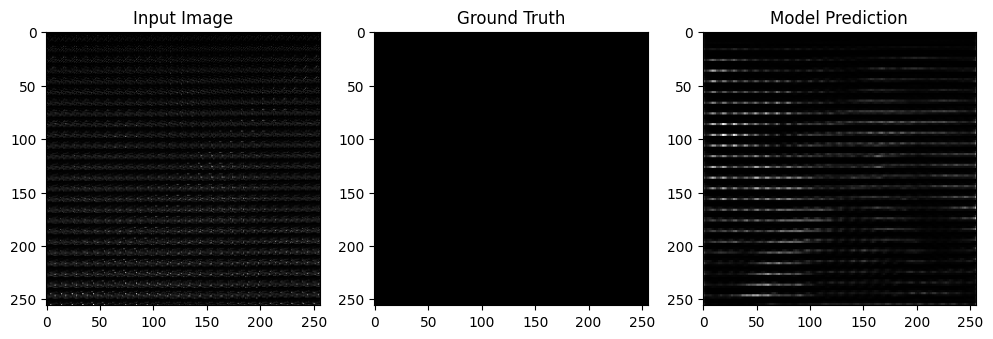

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Normalize data (if needed)
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# Reshape input data to match the model's expected input shape
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)
y_train = y_train.reshape(-1, 256, 256, 1)
y_test = y_test.reshape(-1, 256, 256, 1)

# Create and compile the U-Net model
model = unet_model()
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)



In [ ]:
print(X_train)

[[[[0.00385462]
   [0.00416299]
   [0.00462554]
   ...
   [0.00477972]
   [0.00488251]
   [0.00488251]]

  [[0.0049853 ]
   [0.00513949]
   [0.00513949]
   ...
   [0.00411159]
   [0.00385462]
   [0.00416299]]

  [[0.00462554]
   [0.00477972]
   [0.00488251]
   ...
   [0.00488251]
   [0.0049853 ]
   [0.00513949]]

  ...

  [[0.00527581]
   [0.00426899]
   [0.00385462]
   ...
   [0.00495559]
   [0.00467372]
   [0.00495318]]

  [[0.00533659]
   [0.00592788]
   [0.00599187]
   ...
   [0.00515555]
   [0.0053001 ]
   [0.00431717]]

  [[0.03061429]
   [0.03836694]
   [0.03851555]
   ...
   [0.03007193]
   [0.03169253]
   [0.0320399 ]]]


 [[[0.0354811 ]
   [0.04046921]
   [0.02031574]
   ...
   [0.032385  ]
   [0.00646953]
   [0.00748995]]

  [[0.00659451]
   [0.00856111]
   [0.01272912]
   ...
   [0.01041625]
   [0.00983901]
   [0.00877327]]

  [[0.01880671]
   [0.02039654]
   [0.00822057]
   ...
   [0.00852889]
   [0.01086319]
   [0.01628781]]

  ...

  [[0.00947915]
   [0.01299483]
   [0.0

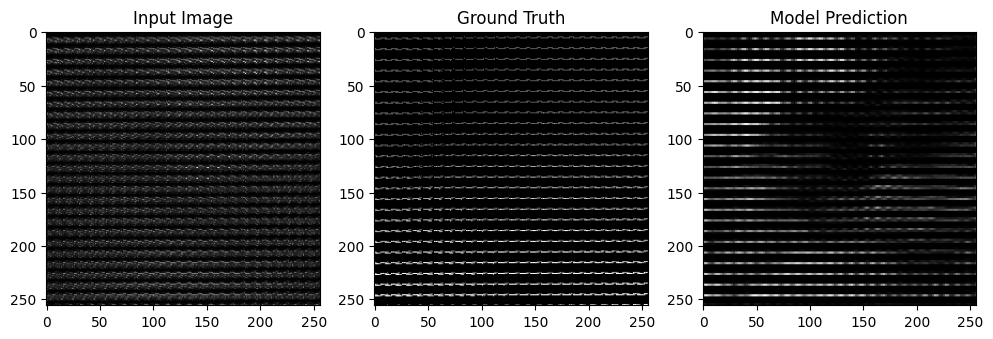

In [ ]:

# Visualize results (optional)
index = 3  # Change this index to visualize different predictions
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[index, ..., 0], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[index, ..., 0], cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(predictions[index, ..., 0], cmap='gray')
plt.title('Model Prediction')

plt.show()


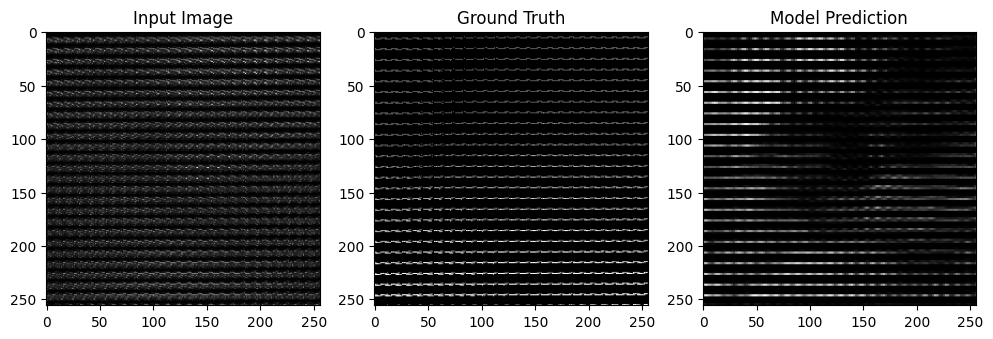

In [ ]:


# Visualize results (optional)
index = 3  # Change this index to visualize different predictions
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[index], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[index], cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(predictions[index], cmap='gray')
plt.title('Model Prediction')

plt.show()


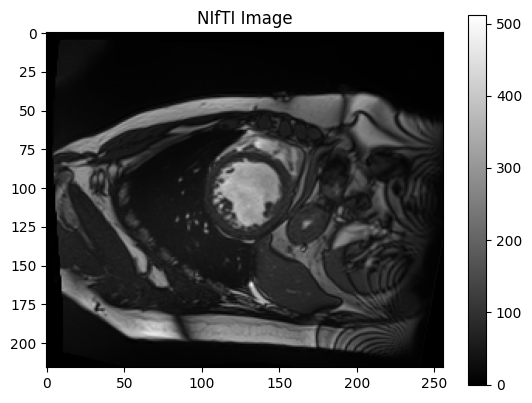

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

def show_nifti_image(nifti_path):
    # Load the NIfTI image
    img = nib.load(nifti_path)

    # Get the image data
    img_data = img.get_fdata()

    # Display a slice (you can modify this to display multiple slices or use a different view)
    slice_index = img.shape[-1] // 2  # Display a slice from the middle of the volume
    plt.imshow(img_data[:, :, slice_index], cmap='gray')  # Assuming a 3D grayscale image
    plt.title('NIfTI Image')
    plt.colorbar()
    plt.show()

# Example usage
nifti_path =  '/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Training/patient001/patient001_frame01.nii.gz'
show_nifti_image(nifti_path)


In [ ]:

def load_data(folder_path, target_shape=(256, 256, 10)):
    X = []
    y = []
    Xpath = []
    ypath = []

    for patient_folder in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, patient_folder)):
            cfg_file = os.path.join(folder_path, patient_folder, f"{patient_folder}.cfg")

            # Get the list of all NIfTI files in the folder
            nifty_files = [f for f in os.listdir(os.path.join(folder_path, patient_folder)) if f.endswith('.nii.gz')]

            # Exclude files containing '4d' in their names
            nifty_files = [file for file in nifty_files if '4d' not in file]
            print(nifty_files)

            for nifty_file in nifty_files:
                if "_gt" in nifty_file:  # Ground truth file
                    y_path = os.path.join(folder_path, patient_folder, nifty_file)
                    y_data = nib.load(y_path).get_fdata()
                    print(f"Shape of {nifty_file}: {y_data.shape}")
                    y.append(y_data)
                    ypath.append(y_path)
                else:  # Input file
                    x_path = os.path.join(folder_path, patient_folder, nifty_file)
                    x_data = nib.load(x_path).get_fdata()
                    print(f"Shape of {nifty_file}: {x_data.shape}")
                    X.append(x_data)
                    Xpath.append(Xpath)
    return X, y,ypath, Xpath



In [ ]:

data_folder = r'/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Training'
X_data, y_data, Xpath, ypath = load_data(data_folder)

['patient039_frame10_gt.nii.gz', 'patient039_frame10.nii.gz', 'patient039_frame01.nii.gz', 'patient039_frame01_gt.nii.gz']
Shape of patient039_frame10_gt.nii.gz: (208, 256, 9)
Shape of patient039_frame10.nii.gz: (208, 256, 9)
Shape of patient039_frame01.nii.gz: (208, 256, 9)
Shape of patient039_frame01_gt.nii.gz: (208, 256, 9)
['patient038_frame11.nii.gz', 'patient038_frame01.nii.gz', 'patient038_frame11_gt.nii.gz', 'patient038_frame01_gt.nii.gz']
Shape of patient038_frame11.nii.gz: (276, 384, 8)
Shape of patient038_frame01.nii.gz: (276, 384, 8)
Shape of patient038_frame11_gt.nii.gz: (276, 384, 8)
Shape of patient038_frame01_gt.nii.gz: (276, 384, 8)
['patient037_frame12.nii.gz', 'patient037_frame01.nii.gz', 'patient037_frame12_gt.nii.gz', 'patient037_frame01_gt.nii.gz']
Shape of patient037_frame12.nii.gz: (216, 256, 7)
Shape of patient037_frame01.nii.gz: (216, 256, 7)
Shape of patient037_frame12_gt.nii.gz: (216, 256, 7)
Shape of patient037_frame01_gt.nii.gz: (216, 256, 7)
['patient035_

In [ ]:

def show_nifti_pair(x_path, y_path):
    # Load NIfTI images
    x_img = nib.load(x_path).get_fdata()
    y_img = nib.load(y_path).get_fdata()

    # Display a slice from the middle of the volume
    slice_index = x_img.shape[-1] // 2

    # Plot X and Y side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(x_img[:, :, slice_index], cmap='gray')
    plt.title('X Image')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(y_img[:, :, slice_index], cmap='gray')
    plt.title('Y Image')
    plt.colorbar()

    plt.show()



for i in range(100):
    show_nifti_pair(Xpath, ypath)

TypeError: ignored